In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pdb
import warnings 
warnings.filterwarnings('ignore')

client = bnb_client(tld='US')

_dict = client.get_exchange_info()['symbols']


In [2]:
univ = []
for i in _dict:
    if 'USDT' in i['symbol'] and 'USD' not in i['symbol'][0:3]:
        univ.append(i['symbol'])
        
print(f"There are {len(univ)} coins found.")

There are 174 coins found.


In [3]:
def get_binance_px(symbol,freq,start_ts = '2021-01-01', end_ts = '2024-09-30'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

# univ = ['BTCUSDT', 'ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '1d'
px = {}
vol = {}
for x in univ:
    data = get_binance_px(x,freq)
    # pdb.set_trace()
    px[x] = data.set_index('open_time')['close']
    vol[x] = data.set_index('open_time')['volume']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
vol = pd.DataFrame(vol).astype(float)
vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

In [4]:
px_adj = px.dropna(axis=1)
vol_adj = vol[px_adj.columns]

In [5]:
form_px = px_adj.loc["2021-01-01":"2022-09-30"]

In [6]:
import binance
import numpy as np
import os
import pandas as pd


class Utils:
    
    def __init__(self, save_portf: str=os.getcwd()) -> None:
        
        self.save_portf = save_portf
        
    def get_binance_px(self, client: binance.client.Client, symbol: str, freq: str, start_ts: str='2021-01-01', end_ts: str='2023-12-31') -> pd.DataFrame:
        
        from datetime import datetime
        
        data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
        columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

        data = pd.DataFrame(data,columns = columns)

        # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
        data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        
        return data 
        
    def turnover(self, portf: pd.DataFrame) -> pd.Series:

        to = (portf.fillna(0) - portf.shift().fillna(0)).abs().sum(axis=1)

        return to

    def ann_sharpe(self, ret: pd.DataFrame) -> float:
        
        avg_ret = ret.mean()
        vol_ret = ret.std()
        sr = avg_ret / vol_ret * np.sqrt(365)

        return sr
    
    def optimal_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        try:
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()  
            
        except np.linalg.LinAlgError as err:
            sigma_value = sigma.iloc[0,0]
            sigma = np.diag(np.full(sigma.shape[0],sigma_value))
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()

        return wgt

    def eqvol_weights(self, sigma: pd.DataFrame) -> pd.Series:
        
        wgt = 1/np.sqrt(np.diag(sigma))
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt

    def sr_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        wgt = mu / np.diag(sigma) 
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt
    
    def save_portfolio(self, portf: pd.DataFrame) -> None:
        
        portf.to_pickle(self.save_portf)
        
        print(f"Dataframe saved to {self.save_porft}")
        
    def drawdown(self, returns):
        # Calculate cumulative returns
        cumulative = (1 + returns).cumprod()

        # Calculate the running maximum
        running_max = cumulative.cummax()

        # Calculate drawdown
        drawdown = (cumulative - running_max) / running_max

        return drawdown
    
    def duration(self, px):

        peak = px.expanding(min_periods=1).max()
        res = pd.DataFrame(index=px.index,columns=px.columns)

        for col in px.columns:
            for dt in px.index:

                if px.loc[dt,col] >= peak.loc[dt,col]:
                    res.loc[dt,col] = 0

                else:    
                    res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1

        return res

In [7]:
class PairsBacktest:
    
    def __init__(self, window: int=60, entry_signal: float=1, exit_signal: float=0.5) -> None:
        
        self.window = window
        self.entry_signal = entry_signal
        self.exit_signal = exit_signal
        
    def get_pairs(self, px: pd.DataFrame) -> list:
        
        n = px.shape[1]
        pairs = []
        
        for i in range(n):
            for j in range(i+1,n):
                
                tmp1 = np.log(px.iloc[:,i])
                tmp2 = np.log(px.iloc[:,j])
                
                corr = tmp1.corr(tmp2)
                
                if corr >= 0.95:
                    pairs.append((tmp1.name, tmp2.name))
                    
        return pairs
    
    def get_signal(self, px: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        signals = {}
        
        for pair in pairs:

            X = np.log(px[pair[0]]).fillna(0)
            Y = np.log(px[pair[1]]).fillna(0)
            X = sm.add_constant(X)

            if len(X) < self.window:
                
                reg = RollingOLS(Y,X,window=(len(X)+2),expanding=True).fit()

                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=(len(X)+2),min_periods=1).mean()) / residual.rolling(window=(len(X)+2),min_periods=1).std()

                signals[(pair,"z-score")] = z_score
                signals[(pair,"beta")] = beta
            
            else:
        
                reg = RollingOLS(Y,X,window=self.window,expanding=True).fit()
                
                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=self.window,min_periods=1).mean()) / residual.rolling(window=self.window,min_periods=1).std()

                signals[(pair,"z-score")] = z_score
                
        signals = pd.DataFrame(signals)
        
        return signals
    
    def get_portfolio(self, px: pd.DataFrame, signals: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        portf = pd.DataFrame(columns=px.columns, index=px.index)
        
        for pair in pairs:
            
            z_score = signals[(pair,"z-score")]
            
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[0]] = 1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[0]] = 0
        
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[1]] = -1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[1]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[0]] = -1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[0]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[1]] = 1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[1]] = 0
            
        portf = portf.ffill()
        portf = portf.divide(portf.abs().sum(axis=1),axis=0).fillna(0)
        
        return portf
    
    def trade_pairs(self, px: pd.DataFrame, rebalance_dates: list, rebalance_val: int) -> (pd.Series, pd.DataFrame):
        
        utils = Utils()
        
        net_ret = pd.Series(index=px.index,name="Pairs Trading")
        # pdb.set_trace()
        net_ret = net_ret.loc[rebalance_dates[1]:]
        
        for ii in range(1,len(rebalance_dates)):
            
            if ii == len(rebalance_dates)-1:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:,:]
            else:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:rebalance_dates[ii+1]-pd.DateOffset(1),:]
            
            pairs = self.get_pairs(form_pairs)
            
            signals = self.get_signal(px=trade_pairs, pairs=pairs)
            
            portf = self.get_portfolio(px=trade_pairs,signals=signals,pairs=pairs)
            
            trade_ret = trade_pairs.pct_change().fillna(0)
            strat_ret = (portf.shift() * trade_ret).sum(axis=1)
            
            to = utils.turnover(portf=portf)
            tcost_bps = 20
            # pdb.set_trace()
            net_ret.loc[trade_pairs.index] = strat_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
            
        net_ret = net_ret.fillna(0)
        
        evaluation = {}

        evaluation['Sharpe Ratio'] = utils.ann_sharpe(net_ret)
        evaluation['Avg. Turnover'] = to.mean()
        evaluation['Holding Period'] = 2 / to.mean()
        evaluation['Annual Returns'] = net_ret.mean() * 365
        evaluation['Annual Volatility'] = net_ret.std() * np.sqrt(365)
        evaluation['T-Cost'] = (to*tcost_bps*1e-4).mean()
        evaluation = pd.DataFrame(evaluation, index=[net_ret.name])
        
        return net_ret, evaluation


In [8]:
window = 90
entry_signal = 1.5
exit_signal = 1.0
rebalance=180

start_rebalance = px.index.get_loc(form_px.index[-1]-pd.DateOffset(rebalance-1))

rebalance_dates = px.iloc[start_rebalance::rebalance].index
trade_px = px.loc[rebalance_dates[0]:,:]

btp = PairsBacktest(window=window,entry_signal=entry_signal,exit_signal=exit_signal)

net_ret_pairs, evaluation_pairs = btp.trade_pairs(px=trade_px,rebalance_dates=rebalance_dates,rebalance_val=rebalance)

In [11]:
class MomentumBacktest:
    
    def __init__(self):
        
        pass

    def calc_vol_portf(self, rets: pd.DataFrame, vol: pd.DataFrame, window: int) -> pd.DataFrame:
        weights = (vol - vol.ewm(span=window).mean()) / vol.ewm(span=window).std() * rets
        portf = weights.subtract(weights.mean(axis=1),axis=0)
        portf = portf.divide(portf.abs().sum(axis=1),axis=0)
        return portf

    def get_portfolio(self, rets: pd.DataFrame, weights: pd.DataFrame) -> pd.DataFrame:
        strat_ret = (rets.shift() * weights).sum(axis=1)
        return strat_ret
    
    def trade_momentum(self, ret: pd.DataFrame, vol: pd.DataFrame, window: int) -> (pd.Series, pd.DataFrame):
        
        utils = Utils()
        
        portf = self.calc_vol_portf(rets=ret, vol=vol, window=window)
        strat_ret = self.get_portfolio(rets=ret, weights=portf)

        to = utils.turnover(portf=portf)
        tcost_bps = 20 # (comissions + slip)
        net_ret = strat_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
        net_ret.name = "Momentum"

        evaluation = {}

        evaluation['Sharpe Ratio'] = utils.ann_sharpe(net_ret)
        evaluation['Avg. Turnover'] = to.mean()
        evaluation['Holding Period'] = 2 / to.mean()
        evaluation['Annual Returns'] = net_ret.mean() * 365
        evaluation['Annual Volatility'] = net_ret.std() * np.sqrt(365)
        evaluation['T-Cost'] = (to*tcost_bps*1e-4).mean()
        evaluation = pd.DataFrame(evaluation,index=[net_ret.name])     
        
        return net_ret, evaluation
        
        

In [12]:
mbt = MomentumBacktest()

trade_mom = px_adj.loc[rebalance_dates[1]:,:].pct_change()

vol_mom = vol_adj.loc[trade_mom.index]

# pdb.set_trace()

net_ret_mom, evaluation_mom = mbt.trade_momentum(ret=trade_mom,vol=vol_mom,window=5)

In [13]:
evaluation_mom

,Sharpe Ratio,Avg. Turnover,Holding Period,Annual Returns,Annual Volatility,T-Cost
Momentum,1.485704,1.44748,1.381712,0.42594,0.286692,0.002895


In [14]:
evaluation_pairs

,Sharpe Ratio,Avg. Turnover,Holding Period,Annual Returns,Annual Volatility,T-Cost
Pairs Trading,3.113781,1.059118,1.888364,1.003739,0.322354,0.002118


<Axes: >

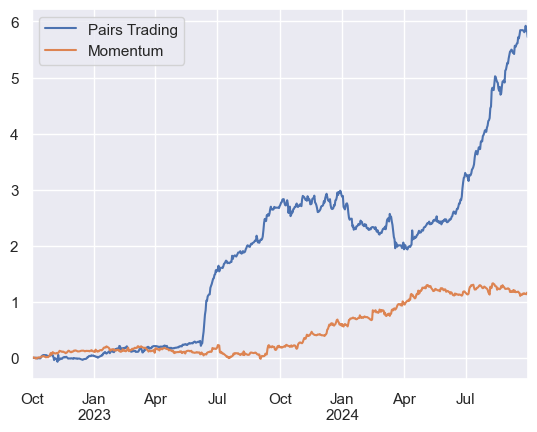

In [15]:
combined = {}
combined[net_ret_pairs.name] = net_ret_pairs
combined[net_ret_mom.name] = net_ret_mom
combined = pd.DataFrame(combined)

((1+combined).cumprod() - 1).plot()

In [16]:
utils = Utils()

combo_rets = pd.DataFrame(columns=['50:50','opt','eqvol','sr'], index=combined.index)

sigma = combined.rolling(window=rebalance,min_periods=1).cov().fillna(1)
mu = combined.rolling(window=5,min_periods=1).mean().fillna(1)

weekly_dates = trade_px.index[rebalance::10]

mu = combined.mean() * 0 + 1
sigma = combined.cov() * 0 + 1

count = 1

for ii in range(1,len(weekly_dates)):
    
    weights = {}
    weights['opt'] = utils.optimal_weights(sigma,mu)
    weights['eqvol'] = utils.eqvol_weights(sigma)
    weights['sr'] = utils.sr_weights(sigma,mu)
    weights['50:50'] = (weights['opt'] / weights['opt']) / combined.shape[1]
    
    weights = pd.DataFrame(weights)
    
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'50:50'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['50:50']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'opt'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['opt']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'eqvol'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['eqvol']).sum(axis=1)
    combo_rets.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),'sr'] = (combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:] * weights['sr']).sum(axis=1)
        
    mu = combined.loc[weekly_dates[ii-1]:weekly_dates[ii]-pd.DateOffset(1),:].mean()
    
    if weekly_dates[ii] in rebalance_dates:
        sigma = combined.loc[rebalance_dates[count]:rebalance_dates[count+1]-pd.DateOffset(1),:].cov()
        count += 1
    
combo_rets = combo_rets.fillna(0)

,Sharpe Ratio,Ann. Returns,Ann. Volatility
50:50,3.384650,0.719348,0.212532
opt,-0.236616,-0.057163,0.241587
eqvol,3.062836,0.658472,0.214988
sr,-0.310053,-0.074756,0.241107


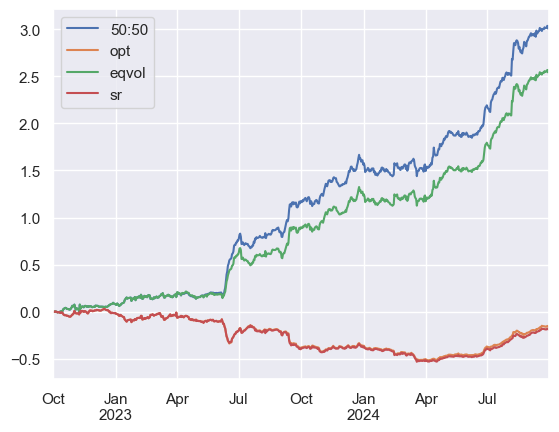

In [17]:
((1+combo_rets).cumprod() - 1).plot()
combo_sr = {}
combo_sr["Sharpe Ratio"] = combo_rets.mean() / combo_rets.std() * np.sqrt(365)
combo_sr["Ann. Returns"] = combo_rets.mean() * 365
combo_sr["Ann. Volatility"] = combo_rets.std() * np.sqrt(365)
combo_sr = pd.DataFrame(combo_sr)
combo_sr

In [18]:
BH = pd.DataFrame(trade_px['BTCUSDT'].pct_change().fillna(0))
BH = BH.iloc[rebalance:,:]
port_bh = pd.Series(np.ones(len(BH)),index=BH.index,name=BH.columns[0])

In [19]:
to_BH = utils.turnover(pd.DataFrame(port_bh))
to_BH.name = port_bh.name
strat_ret_BH = (port_bh.to_frame().shift() * BH)
tcost_bps = 20 # (comissions + slip)
net_ret_BH = strat_ret_BH['BTCUSDT'].subtract(to_BH*tcost_bps*1e-4,fill_value=0)

In [20]:
ret_metrics = {}
ret_metrics['Pairs+Momentum'] = combo_rets['50:50']
# ret_metrics['Pairs+Momentum'] = net_ret_pairs

ret_metrics['B&H'] = net_ret_BH
ret_metrics = pd.DataFrame(ret_metrics)

Max Pairs+Momentum Trading Drawdown: 8.56%
Max Buy-and-Hold BTC Drawdown: 26.12%


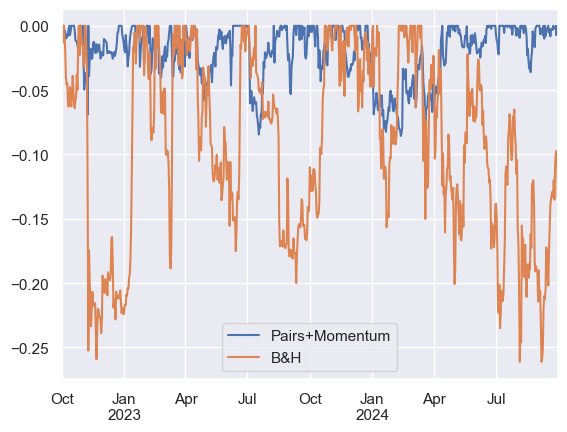

In [21]:
dd = utils.drawdown(ret_metrics)
_ = dd.plot()
print(f"Max Pairs+Momentum Trading Drawdown: {round(abs(dd['Pairs+Momentum'].min())*100,2)}%")
print(f"Max Buy-and-Hold BTC Drawdown: {round(abs(dd['B&H'].min())*100,2)}%")

Max Drawdown Duration for Pairs+Momentum Trading: 109 days
Max Drawdown Duration for Buy-and-Hold BTC: 201 days


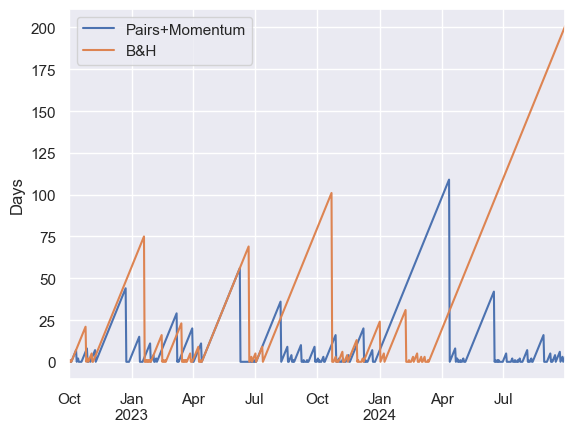

In [22]:
ddd = utils.duration(dd.fillna(0))
_ = ddd.plot()
_ = plt.ylabel("Days")
print(f"Max Drawdown Duration for Pairs+Momentum Trading: {max(ddd['Pairs+Momentum'])} days")
print(f"Max Drawdown Duration for Buy-and-Hold BTC: {max(ddd['B&H'])} days")

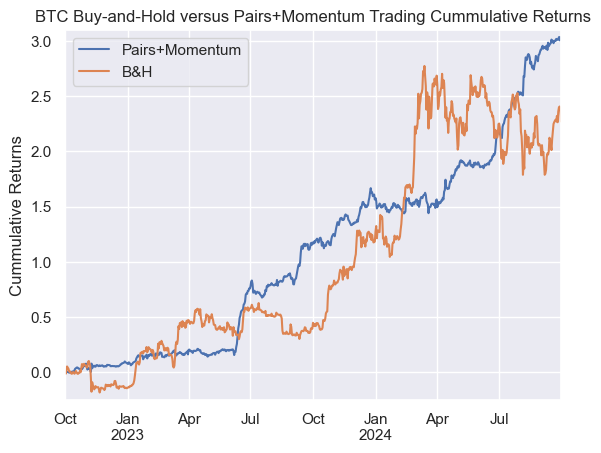

In [23]:
_ = ((1+ret_metrics).cumprod()-1).plot(title="BTC Buy-and-Hold versus Pairs+Momentum Trading Cummulative Returns")
_ = plt.ylabel("Cummulative Returns")
plt.margins(0.02)

In [24]:
combo_rets_eval = {}
combo_rets_eval['Ann. Rets'] = ret_metrics.mean() * 365
combo_rets_eval['Ann. Vol'] = ret_metrics.std() * np.sqrt(365)
combo_rets_eval['Ann. SR'] = combo_rets_eval['Ann. Rets'] / combo_rets_eval['Ann. Vol']
combo_rets_eval = pd.DataFrame(combo_rets_eval)
combo_rets_eval

,Ann. Rets,Ann. Vol,Ann. SR
Pairs+Momentum,0.719348,0.212532,3.384650
B&H,0.710445,0.487912,1.456091


Alpha: 0.0019198031236342399
Alpha Volatility: 0.011104300889160338


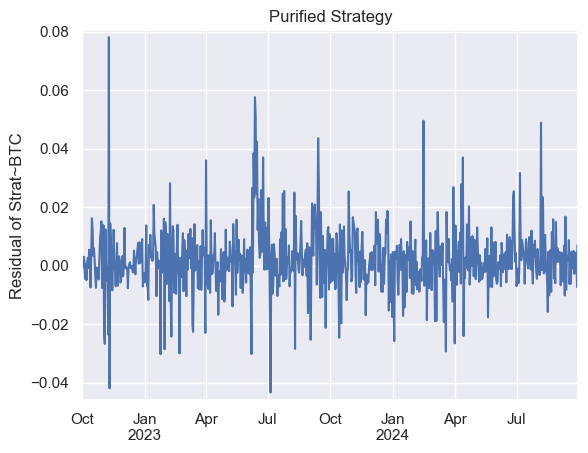

In [25]:
R_BTC = ret_metrics['B&H']
R_BTC = sm.add_constant(R_BTC)

R_Strat = ret_metrics['Pairs+Momentum']

# pdb.set_trace()

model = sm.OLS(R_Strat.astype(float), R_BTC)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
resid = results.resid

alpha_contr = alpha+resid
beta_contr = beta * R_BTC['B&H']

_ = alpha_contr.plot(title="Purified Strategy")
_ = plt.ylabel("Residual of Strat~BTC")
plt.margins(0.02)

print(f"Alpha: {alpha_contr.mean()}")
print(f"Alpha Volatility: {alpha_contr.std()}")

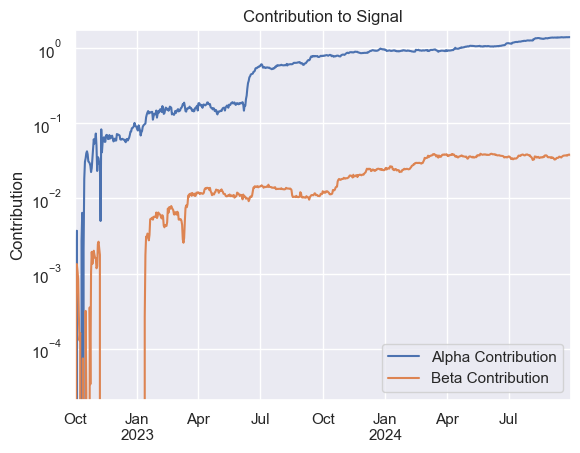

In [26]:
contribution = {}
contribution['Alpha Contribution'] = alpha_contr
contribution['Beta Contribution'] = beta_contr
contribution = pd.DataFrame(contribution)
_ = contribution.cumsum().plot(logy=True, title='Contribution to Signal')
_ = plt.ylabel("Contribution")
plt.margins(0.02)

In [27]:
print(f"Correlation of Alpha to Pairs+Momentum Strategy: {alpha_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Alpha to BTC: {alpha_contr.corr(R_BTC['B&H'])}")
print(f"Correlation of Beta to Pairs+Momentum Strategy: {beta_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Beta to BTC: {beta_contr.corr(R_BTC['B&H'])}")

Correlation of Alpha to Pairs+Momentum Strategy: 0.9981882990126212
Correlation of Alpha to BTC: -5.446709594941254e-17
Correlation of Beta to Pairs+Momentum Strategy: 0.06016743067714911
Correlation of Beta to BTC: 1.0


In [28]:
ir = alpha_contr.mean() / alpha_contr.std() * np.sqrt(365)
print(f"Information Ratio: {ir}")

Information Ratio: 3.3030253361775617


In [30]:
summary_stats = {}
summary_stats['Ann. Returns'] = combo_rets_eval.loc['Pairs+Momentum','Ann. Rets']
summary_stats['Ann. Volatility'] = combo_rets_eval.loc['Pairs+Momentum','Ann. Vol']
summary_stats['Ann. Sharpe Ratio'] = combo_rets_eval.loc['Pairs+Momentum','Ann. SR']
summary_stats['Ann. Information Ratio'] = ir

summary_stats = pd.DataFrame(summary_stats, index=['Pairs+Momentum'])
summary_stats

,Ann. Returns,Ann. Volatility,Ann. Sharpe Ratio,Ann. Information Ratio
Pairs+Momentum,0.719348,0.212532,3.38465,3.303025
